In [63]:
import numpy as np
import torchvision.models as models
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, roc_auc_score
from medmnist import ChestMNIST
from PIL import Image


In [2]:
def load_data(data_split, image_nxn_size, n_observations):
    data = ChestMNIST(split=data_split, download=True, size=image_nxn_size)

    if n_observations > 0:
        images = data.imgs[0:n_observations]
        labels = data.labels[0:n_observations]
    else:      
        images = data.imgs
        labels = data.labels

    del data

    return images, labels

In [3]:
train_images, train_labels = load_data(data_split="train", image_nxn_size=224, n_observations=1000)
validation_images, validation_labels = load_data(data_split="val", image_nxn_size=224, n_observations=1000)
test_images, test_labels = load_data(data_split="test", image_nxn_size=224, n_observations=1000)

Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz
Using downloaded and verified file: /Users/thollenbeak/.medmnist/chestmnist_224.npz


In [4]:
def preprocess_data(image_set):
    preprocess = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    transformed_images = []

    for image in tqdm.tqdm(image_set):
        image = np.float32(image) / 255.0
        image = Image.fromarray(image)
        transformed_images.append(preprocess(image))

    return torch.stack(transformed_images)

In [5]:
x_train_tensor = preprocess_data(train_images)
x_validation_tensor = preprocess_data(validation_images)
x_test_tensor = preprocess_data(test_images)

100%|██████████| 1000/1000 [00:00<00:00, 2017.70it/s]


In [6]:
# Debugging
# num_images = len(transformed_images)
# image_size = transformed_images[0].numel()  # Number of elements in one image
# dtype_size = transformed_images[0].element_size()  # Size of each element in bytes
# total_memory = num_images * image_size * dtype_size
# print(f"Total memory required: {total_memory / (1024 ** 3):.2f} GB")

In [7]:
y_train_tensor = torch.tensor(train_labels)
y_validation_tensor = torch.tensor(validation_labels)
y_test_tensor = torch.tensor(test_labels)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
validation_dataset = TensorDataset(x_validation_tensor, y_validation_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Create DataLoaders for efficient training and testing data handling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, shuffle=False)  
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  

In [99]:
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT, progress=True)

In [100]:
model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [101]:
# model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.DEFAULT, progress=True)
model = models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.DEFAULT, progress=True)
n_features = 9

for param in model.features[:n_features].parameters():
    param.requires_grad = False

for param in model.features[n_features:].parameters():
    param.requires_grad = True

# model.classifier[1] = nn.Conv2d(512, train_labels.shape[1], kernel_size=(1, 1), stride=(1, 1))
# model.classifier[2] = nn.Identity()

model.classifier[3] = nn.Linear(in_features=1024, out_features=train_labels.shape[1], bias=True)

In [102]:
optimizer = optim.Adam(model.parameters(), lr = 0.1)
#scheduler = StepLR(optimizer, step_size = 2, gamma = 0.5)
criterion = nn.BCEWithLogitsLoss()

In [10]:
# with torch.no_grad():
#     for data, label in train_loader:
#         #print(data.shape, label.shape)
#         validation_outputs = model(data)
#         validation_targets = label
#         print(validation_outputs)
#         #print(criterion(validation_outputs, validation_targets))
#         break

In [103]:
best_model_path = "best_transfer_learning_model.pth"
best_loss = np.inf
best_accuracy = 0
best_epoch = 0
sigmoid_threshold = 0.25

for epoch in range(5):
    model.train()
    
    for inputs, targets in tqdm.tqdm(train_loader, desc="Training: "):
        optimizer.zero_grad()
        outputs = model(inputs)
        targets = targets.float()

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    all_targets = []
    all_predictions = []
    validation_loss = 0.0
    validation_accuracy = 0.0
    
    with torch.no_grad():
        for validation_inputs, validation_targets in validation_loader:
            validation_outputs = model(validation_inputs)
            validation_targets = validation_targets.float()
            validation_loss += criterion(validation_outputs, validation_targets)

            probabilities = torch.sigmoid(validation_outputs)
            predictions = (probabilities > sigmoid_threshold).float()

            all_targets.extend(validation_targets)
            all_predictions.extend(predictions)

    validation_accuracy = accuracy_score(all_targets, all_predictions)
    validation_loss /= len(validation_loader.dataset)

    if validation_loss < best_loss:
        best_loss = validation_loss
    
    # Save the model with the best accuracy
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save(model.state_dict(), best_model_path)

    print(f"Epoch: {epoch + 1}, Validation Loss: {validation_loss}, Accuracy: {validation_accuracy}")

Training: 100%|██████████| 16/16 [00:25<00:00,  1.60s/it]


Epoch: 1, Validation Loss: 3209.887451171875, Accuracy: 0.564


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch: 2, Validation Loss: 20.97370147705078, Accuracy: 0.564


Training: 100%|██████████| 16/16 [00:24<00:00,  1.53s/it]


Epoch: 3, Validation Loss: 1.889235258102417, Accuracy: 0.564


Training: 100%|██████████| 16/16 [00:25<00:00,  1.59s/it]


Epoch: 4, Validation Loss: 0.30102279782295227, Accuracy: 0.564


Training: 100%|██████████| 16/16 [00:26<00:00,  1.68s/it]


Epoch: 5, Validation Loss: 0.08154334127902985, Accuracy: 0.564


In [104]:
model.load_state_dict(torch.load("best_transfer_learning_model.pth", weights_only=True))
model.eval()

all_targets = []
all_predictions = []
test_loss = 0.0

with torch.no_grad():
    for test_inputs, test_targets in tqdm.tqdm(test_loader, desc="Testing:"):
        test_outputs = model(test_inputs)
        test_targets = test_targets.float()
        test_loss += criterion(test_outputs, test_targets)

        probabilities = torch.sigmoid(test_outputs)
        predictions = (probabilities > sigmoid_threshold).float()

        all_targets.extend(test_targets)
        all_predictions.extend(predictions)

#print(all_predictions)
test_loss /= len(validation_loader.dataset)
test_hamming_loss = hamming_loss(all_targets, all_predictions)
test_accuracy = accuracy_score(all_targets, all_predictions)
test_precision = precision_score(all_targets, all_predictions, average="micro")
test_recall = recall_score(all_targets, all_predictions, average="micro")
test_f1_score = f1_score(all_targets, all_predictions, average="micro")
test_roc_auc = roc_auc_score(all_targets, all_predictions)

print(f"Test Loss: {test_loss}")
print(f"Hamming Loss: {test_hamming_loss}")
print(f"Accuracy: {test_accuracy}")
print(f"Precision: {test_precision}")
print(f"Recall: {test_recall}")
print(f"F1 Score: {test_f1_score}")
print(f"ROC AUC: {test_roc_auc}")


Testing:: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

Test Loss: 3391.96337890625
Hamming Loss: 0.052142857142857144
Accuracy: 0.533
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
ROC AUC: 0.5



/opt/anaconda3/envs/DS440/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
# Try using the CNN as a feature extractor for traditional ML methods
# Include a larger classification layer for finetuning
# Address potential class imbalance

In [61]:
example_image = test_dataset[:1][0]
example_label = test_dataset[:1][1]

In [59]:
example_logits = model(example_image)
example_probabilities = torch.sigmoid(example_logits)
example_predictions = (example_probabilities > sigmoid_threshold).float()

In [60]:
example_predictions

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [62]:
example_label

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.uint8)

In [105]:
model.eval()

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (activation): ReLU()
          (scale_activation): Hardsigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), 

In [106]:
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

example_image = Image.open("Example.png")
grad_cam_image = np.float32(example_image) / 255.0
grad_cam_image = Image.fromarray(grad_cam_image)
grad_cam_image = preprocess(grad_cam_image).unsqueeze(0)

In [107]:
target_layer = model.features[-1]
grad_cam = GradCAM(model=model, target_layers=target_layer)

In [108]:
grayscale_cam = grad_cam(grad_cam_image)

In [111]:
import numpy as np
import matplotlib.pyplot as plt

cam_image = grayscale_cam[0, :]
cam_image = np.uint8(cam_image * 255)
cam_image = np.expand_dims(cam_image, axis=-1)
cam_image = np.repeat(cam_image, 3, axis=-1)

# Overlay the heatmap onto the original image
heatmap = Image.fromarray(cam_image)
heatmap = heatmap.resize(example_image.size, resample=Image.Resampling.LANCZOS)
heatmap = np.array(heatmap) / 255.0

superimposed_img = np.array(example_image) / 255.0
superimposed_img = superimposed_img * (1 - 0.4) + heatmap * 0.4

# Display the result
plt.imshow(superimposed_img)
plt.show()

ValueError: operands could not be broadcast together with shapes (1024,1024) (1024,1024,3) 

In [64]:
model.eval()

target_layers = [model.features[-1]]
input_tensor = [example_image]# Create an input tensor image for your model..
# Note: input_tensor can be a batch tensor with several images!

targets = []

# We have to specify the target we want to generate the CAM for.
for i in range(train_labels[1].shape):
  targets.append(ClassifierOutputTarget(i))

# targets = [ClassifierOutputTarget(0)]

# Construct the CAM object once, and then re-use it on many images.
with GradCAM(model=model, target_layers=target_layers) as cam:
  # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
  grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
  # In this example grayscale_cam has only one image in the batch:
  grayscale_cam = grayscale_cam[0, :]
  visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
  # You can also get the model outputs without having to redo inference
  model_outputs = cam.outputs

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

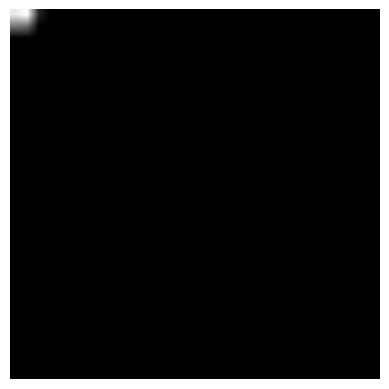

In [116]:
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
image = Image.open("Example.png")

# Preprocessing steps specific to MobileNetV3
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension

# Generate the Grad-CAM heatmap
grayscale_cam = grad_cam(input_tensor)

# Convert grayscale cam to RGB for visualization
cam_image = grayscale_cam[0, :]
cam_image = np.uint8(cam_image * 255)
cam_image = np.expand_dims(cam_image, axis=-1)
cam_image = np.repeat(cam_image, 3, axis=-1)  # Convert heatmap to 3-channel RGB format

# Resize heatmap to match the original image size
heatmap = Image.fromarray(cam_image)
heatmap = heatmap.resize(image.size, resample=Image.Resampling.LANCZOS)
heatmap = np.array(heatmap) / 255.0  # Normalize the heatmap

# Convert the original image to RGB and normalize it
superimposed_img = np.array(image) / 255.0  # Normalize the original image to [0, 1]

# Perform overlay with heatmap
#superimposed_img = superimposed_img * (1 - 0.4) + heatmap * 0.4

# Display the result
plt.imshow(heatmap)
plt.axis('off')  # Turn off axis for better visualization
plt.show()
